'Sample 4 - Least-squares fitting.ipynb' 9/1/19 D. Candela

# Sample notebook 4: Least-squares fitting of data

This builds on **Sample notebook 3: Reading data from a file.** This notebook is rather long as it demonstrates various features and options for least-squares fitting.  But the basic code needed to fit a model to some data is not long and it is shown right near the beginning.

Most of the examples in this notebook use the module `dfit.py`, which **must be copied into the same folder as the notebook (.ipynb) file.**  This module provides a simplified interface to the fitting function `scipy.optimize.curve_fit`.  At the end of this notebook there is an example that calls `curve_fit` directly without using `dfit.py`.

As in Sample notebook 3, here is code to read in and plot the data in `data0.txt` which has two columns, $x$-values and $y$-values, for an imaginary experiment:

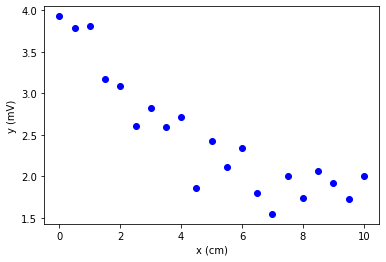

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# Read in the data
darray = np.loadtxt('data0.txt')

# Slice out the x and y columns
xs = darray[:,0]
ys = darray[:,1]

# Plot the data
plt.plot(xs,ys,'bo')
plt.xlabel('x (cm)')
plt.ylabel('y (mV)')
plt.show()

Here is code that:
 - Fits this data to a quadratic model $y = p_0 + p_1 x + p_2 x^2$.
 - Plots the data together with the fitted model.
 - Prints out the goodness-of-fit parameter $\chi^2_r$, the parameters $p_0, p_1$ and the parameter uncertainties.

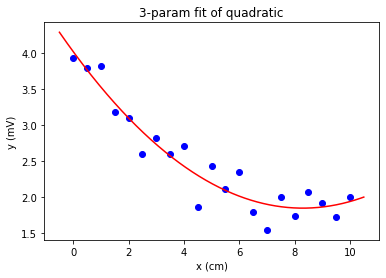

DATA SET: 21 points
FITTING FUNCTION: quadratic, 3 variable parameters
Chi-squared = 0.9069  Reduced chi-squared = 0.05039 (no yerrs supplied)
Parameters and 2-sigma parameter uncertainties:
        p0 = 4.0145      +/- 0.26797    
        p1 = -0.52191    +/- 0.12418    
        p2 = 0.031458    +/- 0.011989   


In [2]:
# Import from dfit.py, which must be in same folder as this notebook
from dfit import Dfit  

# Define the model function
def quadratic(x,p0,p1,p2):
    ymod = p0 + p1*x + p2*x**2
    return ymod

# Fit the data (can use any name in place of fit)
fit = Dfit(quadratic,xs,ys)

# Plot the fit and data together
fit.plotfit(xlabel='x (cm)',ylabel='y (mV)')

# Print chi-squared and the parameter estimates
# and uncertainties
fit.printfit()

Like all `import` statements, The statement `from dfit import Dfit` only needs to be executed once -- be sure to capitalize as shown.

What are **two-sigma parameter uncertainties**?  Under certain assumptions, there is **95% likelihood that the actual parameters values are in these intervals.** Sometimes you see one-sigma parameter uncertainties, which are half as wide.  These is only 68% likelihood that the parameters are in the one-sigma intervals, i.e. there is a one-in-three chance that the parameters are outside the one-sigma intervals.

In the code above the model $y = p_0 + p_1 x + p_2 x^2$ is defined by the following **Python function definition:**

In [3]:
def quadratic(x,p0,p1,p2):
    ymod = p0 + p1*x + p2*x**2
    return ymod

**Notes on writing a model function like this:**
- The function name (`quadratic`) must be followed by the list of function arguments enclosed in round parentheses, followed by a colon.
- For our purposes the argument list must be must the independent variable (`x`) followed by the fitting parameters (`p0`,`p1`,`p2`).  These things can be given any logical names, but they must be in this order.
- The function name and the fitting parameter names are used when the results are printed. So choose meaningful names!
- The **body of the function** is **all indented by the same amount**.  The standard Python indent is four spaces, which Jupyter will do/undo automatically when you hit tab/shift-tab.
- Within the function local variables like `ymod` above can be created simply by using them -- there are no variable declarations in Python.
- The function body should end with `return` followed by an expression for the model value (`ymod`) computed from the independent variable and the fitting parameters.


(In case you are interested: 

`from dfit import Dfit` imports the class `Dfit` from the module `dfit.py`.

`fit = Dfit(quadratic,xs,ys)` carries out the fit and stores the results in the variable `fit`.

`fit.plotfit(..)` uses the stored fitting results to make a plot, and `fit.printfit()` prints out the stored fitting results.

Various options for controlling the fit and the display of the results are shown in the examples below which can simply be copied, but you could also run `help(Dfit)` or look at the code in `dfit.py`.)

### Supplying parameter guesses

Take a look at the file `wavedata.txt` then read it in and plot it:

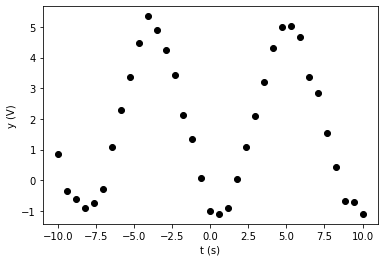

In [4]:
darray = np.loadtxt('wavedata.txt',skiprows=1)
ts = darray[:,0]
ys = darray[:,1]
plt.plot(ts,ys,'ko')
plt.xlabel('t (s)')
plt.ylabel('y (V)')
plt.show()

This data cries out to be fit to a sine or cosine function, with parameters to scale the amplitude $A$, angular frequency $\omega$, phase $\phi$, and vertical offset $B$:
$$
    y = A\cos(\omega t + \phi) + B.
$$

However, when we copy the fitting example above to try this, the results are terrible:

C:\Users\dc\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


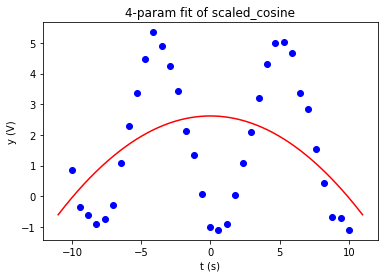

DATA SET: 35 points
FITTING FUNCTION: scaled_cosine, 4 variable parameters
Chi-squared = 139.2  Reduced chi-squared = 4.49 (no yerrs supplied)
Parameters and 2-sigma parameter uncertainties:
        aa = 7612.2      +/- inf        
     omega = 0.0026444   +/- inf        
       phi = -1.4378e-13 +/- inf        
        bb = -7609.5     +/- inf        


In [5]:
from numpy import cos

# Define the model function
def scaled_cosine(t,aa,omega,phi,bb):
    ymod = aa*cos(omega*t + phi) + bb
    return ymod

# Fit the data
wavefit = Dfit(scaled_cosine,ts,ys)

# Plot the fit and data together, and print the results
wavefit.plotfit(xlabel='t (s)',ylabel='y (V)')
wavefit.printfit()

The problem is that the fitting function `curve_fit` has gotten **trapped in a local minimum of $\chi^2$**.  Specifically the frequency $\omega$ is way too low -- there is only small fraction of a cycle across the graph, rather than about two whole cycles.  `curve_fit` can't increase $\omega$ smoothly to the correct value without making $\chi^2$ go up before it goes back down, so it is trapped.

The solution is to provide **parameter guesses** that are  at least vaguely close to the best-fit values:
- The default parameter guesses are all parameters equal to zero.  This works fine in many cases, but not for things like a cosine function that can easily get trapped.
- There is no need for the parameter guesses to be highly accurate -- they just need to be good enough for `curve_fit` to "see" the global minimum of $\chi^2$.  There is no value to fine-tuning the parameter guesses once the global minimum is found.
- There is often no need to supply guesses for all of the parameters.

**Parameter guesses are supplied as a list, using the optional argument `p0s` to `Dfit` as shown in the example below**. Eyballing the data, there are about two cycles in 20 s, so $\omega \approx 12/20 = 0.6$ rad/s.

In the code below `p0s=[0,0.6]` is supplied to `Dfit`.  This means supply a guess of zero for the first parameter $A$ and a guess of 0.6 for the second parameter $\omega$.  **Any guesses not supplied are zero** (here $\phi$, $B$).  Supplying the guess $\omega=0.6$ and  leaving the other three parameter guesses at zero is enough to get a good fit:

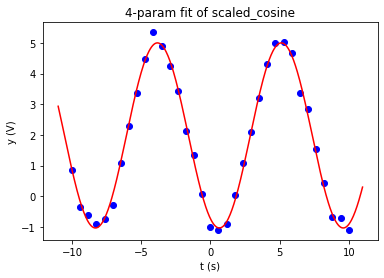

DATA SET: 35 points
FITTING FUNCTION: scaled_cosine, 4 variable parameters
Chi-squared = 1.145  Reduced chi-squared = 0.03695 (no yerrs supplied)
Parameters and 2-sigma parameter uncertainties:
        aa = -3.0175     +/- 0.091145   
     omega = 0.70164     +/- 0.0055415  
       phi = -0.4565     +/- 0.031254   
        bb = 1.985       +/- 0.066684   


In [6]:
# Re-fit the data, now supplying guess for om
wavefit = Dfit(scaled_cosine,ts,ys,
              p0s=[0,0.6])

# Plot the fit and data together, and print the results
wavefit.plotfit(xlabel='t (s)',ylabel='y (V)')
wavefit.printfit()

You may notice that the fitted amplitude $A$ is negative, because there are equally good fits with positive and negative $A$'s with phases $\phi$ differing by $\pi$. If you don't like $A<0$, you can supply a guess for the phase that is $\pi$ away from the fitted value above, $\phi = -0.46 + \pi \approx 2.5$:

In [7]:
wavefit = Dfit(scaled_cosine,ts,ys,
              p0s=[0,0.6,2.5])
wavefit.printfit()

DATA SET: 35 points
FITTING FUNCTION: scaled_cosine, 4 variable parameters
Chi-squared = 1.145  Reduced chi-squared = 0.03695 (no yerrs supplied)
Parameters and 2-sigma parameter uncertainties:
        aa = 3.0175      +/- 0.091145   
     omega = 0.70164     +/- 0.0055415  
       phi = 2.6851      +/- 0.031254   
        bb = 1.985       +/- 0.066684   


### Supplying a name for the data set and units for the parameters

These are done supplying the optional arguments `datname` and `units` to `Dfit`, as shown in the example below.

These arguments have no effect on the numerical results, but they make the plot and output listing clearer particularly when more than one data set is being fit and for parameters like angles that logically could be given in various different units.


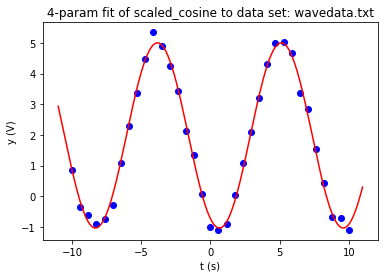

DATA SET: wavedata.txt, 35 points
FITTING FUNCTION: scaled_cosine, 4 variable parameters
Chi-squared = 1.145  Reduced chi-squared = 0.03695 (no yerrs supplied)
Parameters and 2-sigma parameter uncertainties:
        aa = 3.0175      +/- 0.091145   V
     omega = 0.70164     +/- 0.0055415  rad/s
       phi = 2.6851      +/- 0.031254   rad
        bb = 1.985       +/- 0.066684   V


In [8]:
wavefit = Dfit(scaled_cosine,ts,ys,
               p0s=[0,0.6,2.5],
               datname='wavedata.txt',
               units=['V','rad/s','rad','V'])
wavefit.plotfit(xlabel='t (s)',ylabel='y (V)')
wavefit.printfit()

### Trying models of different orders

At the start of this notebook some data was fit to a quadratic -- by why not use a cubic or higher-order polynomial?  The correct way to answer this, i.e. **to find out which terms in a model are justified by the data** is to try fits of different orders and look at the trends of $\chi^2_r$ and the parameter uncertainties.

Here is how to do this with `dfit`.  A high-order polynomial is used as the fitting function, and **the optional argument `varies` is used to set which terms are allowed to vary in the fit:**  

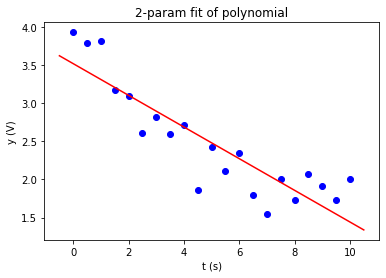

DATA SET: 21 points
FITTING FUNCTION: polynomial, 2 variable parameters
Chi-squared = 2.294  Reduced chi-squared = 0.1208 (no yerrs supplied)
Parameters and 2-sigma parameter uncertainties:
        p0 = 3.5164      +/- 0.2928     
        p1 = -0.20733    +/- 0.050093   
        p2 = 0.0             (fixed)    
        p3 = 0.0             (fixed)    
        p4 = 0.0             (fixed)    
        p5 = 0.0             (fixed)    


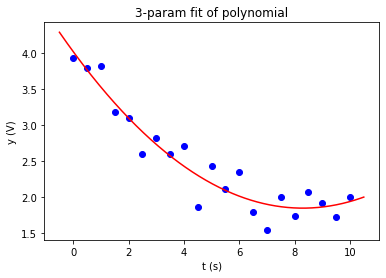

DATA SET: 21 points
FITTING FUNCTION: polynomial, 3 variable parameters
Chi-squared = 0.9069  Reduced chi-squared = 0.05039 (no yerrs supplied)
Parameters and 2-sigma parameter uncertainties:
        p0 = 4.0145      +/- 0.26797    
        p1 = -0.52191    +/- 0.12418    
        p2 = 0.031458    +/- 0.011989   
        p3 = 0.0             (fixed)    
        p4 = 0.0             (fixed)    
        p5 = 0.0             (fixed)    


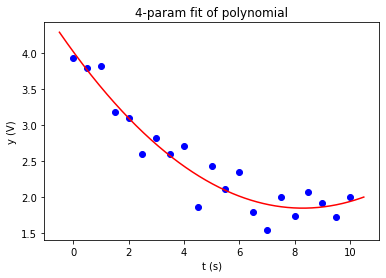

DATA SET: 21 points
FITTING FUNCTION: polynomial, 4 variable parameters
Chi-squared = 0.9069  Reduced chi-squared = 0.05335 (no yerrs supplied)
Parameters and 2-sigma parameter uncertainties:
        p0 = 4.0144      +/- 0.34073    
        p1 = -0.52171    +/- 0.30247    
        p2 = 0.031405    +/- 0.07131    
        p3 = 3.558e-06   +/- 0.0046823  
        p4 = 0.0             (fixed)    
        p5 = 0.0             (fixed)    


In [9]:
# Read in data (same as first example)
darray = np.loadtxt('data0.txt')
xs = darray[:,0]
ys = darray[:,1]

# Model function is polynomial up to x**5
def polynomial(x,p0,p1,p2,p3,p4,p5):
    return (p0 + p1*x + p2*x**2 + p3*x**3 + p4*x**4
            + p5*x**5)

# Do three fits using 2, 3, 4 terms
linfit = Dfit(polynomial,xs,ys,varies=[True,True])
quadfit = Dfit(polynomial,xs,ys,varies=[True,True,True])
cubfit = Dfit(polynomial,xs,ys,varies=[True,True,True,True])

# Plot and print results
linfit.plotfit(xlabel='t (s)',ylabel='y (V)')
linfit.printfit()

quadfit.plotfit(xlabel='t (s)',ylabel='y (V)')
quadfit.printfit()

cubfit.plotfit(xlabel='t (s)',ylabel='y (V)')
cubfit.printfit()

First look at the reduced chi-squared:  Going from a linear fit to a quadratic fit, $\chi^2_r$ decreases dramatically from 0.12 to 0.05, but continuing to a cubic fit $\chi^2_r$ remains at about 0.05.  This indicates that including the cubic term did not improve the fit statistically, which corresponds to the appearances of the plots.

Next look at the parameter uncertainties: For the linear and quadratic fits, all parameter uncertainties are less than the corresponding parameters.  But for the cubic fit, the uncertainties for $p_2$ and especially $p_3$ are bigger than the parameters themselves.

Both of these things indicate that **a cubic fit to these data is not justified**, even though the cubic fitting function is slightly closer to the data points than the quadratic fitting function.

### Fixing parameters

Here is how the optional argument `varies` works:
- If `varies` is not supplied, all fitting parameters are allowed to vary.
- If `varies` is supplied, it must be a list of `True` and `False` (captialized!) and only the parameters that have `True` are allowed to vary.  Furthermore, if `varies` is shorter than the number of parameters then for convenience all the remaining parameters are fixed.
- To supply values other than zero for parameters that are fixed, use the optional argument `p0s` (same as used to supply parameter guesses).

    Here is an example.  The quadratic fit above is repeated, but now fixing the linear term to $p_1 = -0.5$, slightly different from the best-fit value of -0.522.  Note that $\chi^2$ (not $\chi^2_r$) is slightly larger than when $p_1$ was allowed to vary, indicating that the fit is slightly further from the data points:

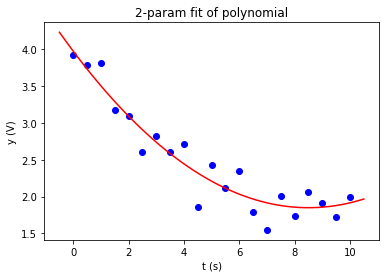

DATA SET: 21 points
FITTING FUNCTION: polynomial, 2 variable parameters
Chi-squared = 0.9132  Reduced chi-squared = 0.04806 (no yerrs supplied)
Parameters and 2-sigma parameter uncertainties:
        p0 = 3.9747      +/- 0.1415     
        p1 = -0.5            (fixed)    
        p2 = 0.029415    +/- 0.0030511  
        p3 = 0.0             (fixed)    
        p4 = 0.0             (fixed)    
        p5 = 0.0             (fixed)    


In [10]:
fitf = Dfit(polynomial,xs,ys,varies=[True,False,True],
           p0s=[0,-.5])
fitf.plotfit(xlabel='t (s)',ylabel='y (V)')
fitf.printfit()

### Fitting data with known uncertainties

Some experiments produce experiments with known uncertainties.  For example, for a typical radioactive decay experiment in which the number of decays in fixed time bins are counted, the uncertainty for each $y$-value (number of counts) is $\sqrt{y}$.

The file `decay1.txt` contains the following made-up data, which could have come from such an experiment:
```
   t (min) counts/min
         0        192
         8        169
        16        148
        24        115
        32        110
        40        103
        48         78
         .          .
         .          .
         .          .
```
Here is code to read in this data, compute the uncertainties as the square roots of the data values, and plot the data with error bars:

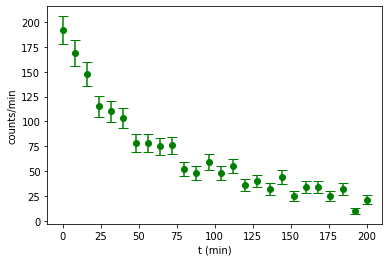

In [11]:
# Read the data from file
from numpy import sqrt

data = np.loadtxt('decay1.txt', float,skiprows=1)
tdat = data[:,0]  # slice out first column (t values)
ndat = data[:,1] # slice out second column (n values)

# Compute counting sigmas as square roots of n values
sigdat = sqrt(ndat)

# Plot with error bars
plt.errorbar(tdat,ndat,sigdat,fmt='go',capsize=5)
plt.xlabel('t (min)')
plt.ylabel('counts/min')
plt.show()

Here is code to fit this data to the three-parameter model $n(t) = n_0 \exp(-t/\tau) + B$. **The data uncertainties are supplied to `Dfit` using the optional argument `yerrs`** which we have not used until now.

This fit gets trapped if no parameter guesses are supplied. Eyeballing the data the initial value is $n_0 \approx 200$ and the counts decay by $1/e$ in $\tau \approx 50$ min, so these values are used as guesses:

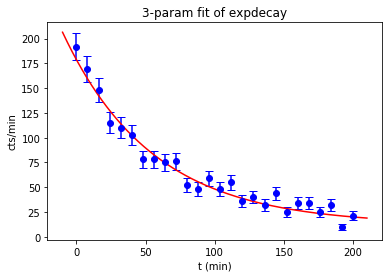

DATA SET: 26 points
FITTING FUNCTION: expdecay, 3 variable parameters
Chi-squared = 38.64  Reduced chi-squared = 1.68
Parameters and 2-sigma parameter uncertainties:
        n0 = 166.69      +/- 18.715     
       tau = 65.206      +/- 17.294     
        bb = 12.159      +/- 10.32      


In [12]:
from numpy import exp

def expdecay(t,n0,tau,bb):
    """Model function: exponential decay plus background"""
    return n0*exp(-t/tau)+bb

efit = Dfit(expdecay,tdat,ndat,yerrs=sigdat,
           p0s=[200,50])
efit.plotfit(xlabel='t (min)',ylabel='cts/min')
efit.printfit()

Because the uncertainties for the data are known, the absolute value of $\chi^2_r$ is meaningful here (unlike all the previous examples), and we expect $\chi^2_r \approx 1$ if the model describes the data well.

Here is the same fit, except now with the background term $B$ fixed as it might be if the background were independently measured:

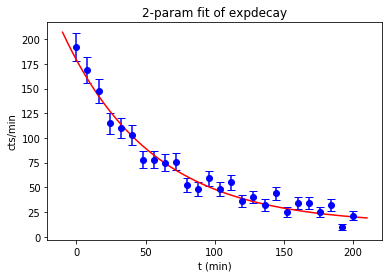

DATA SET: 26 points
FITTING FUNCTION: expdecay, 2 variable parameters
Chi-squared = 38.65  Reduced chi-squared = 1.61
Parameters and 2-sigma parameter uncertainties:
        n0 = 166.73      +/- 18.389     
       tau = 64.677      +/- 7.4483     
        bb = 12.5            (fixed)    


In [13]:
efitb = Dfit(expdecay,tdat,ndat,yerrs=sigdat,
           varies=[True,True],p0s=[200,50,12.5])
efitb.plotfit(xlabel='t (min)',ylabel='cts/min')
efitb.printfit()

### Getting the fitted parameters and uncertainties.

Once a fit has been carried out by  initializing a `Dfit` object, you may want to use the results to make your own plots and printouts rather than using `plotfit` or `printfit`, or to use the results as input to some other calculations.

The fitted parameters and the two-sigma parameter uncertainties are available as the attributes `ps` and `ups` of a `Dfit` object (fixed parameters will have zero uncertainty listed).  Thus, for the fit done immediately above:

In [14]:
print(f'Fitted parameters: {efitb.ps}')
print(f'Parameter uncertainties: {efitb.ups}')

Fitted parameters: [166.7349666017445, 64.67727671800756, 12.5]
Parameter uncertainties: [18.389423974497337, 7.44828436232927, 0.0]


### Using `curve_fit` directly rather than using `dfit.py`

Rather than using `dfit.py`, the fitting function `scipy.optimize.curve_fit` can be called directly.  This provides more options when doing the fit.  However, the code is more complex, as can be seen in the following cell.  Specifically the code in`dfit.py` carries out the following tasks, which must be done by user code if `dfit.py` is not used:
- The model function is plotted as a curve by using `np.linspace` to make an array of finely-spaced $x$ points, then evaluating the model function at these points with the fitted paramters.
- Chi-squared is computed by evaluating the model function at the data $x$ values and summing the squares of the differences from the data $y$ values.
- The parameter uncertainties are evaluated from the diagonal of the covariance matrix returned by `curve_fit`.

Also, when using `curve_fit` directly there is no easy way to  optionally fix some of the parameters, which is useful when deciding on an appropriate model for the data.

The code in this cell duplicates the first fit done near the beginning of this notebook, and has been written so it can be executed on its own without executing any other cells above:

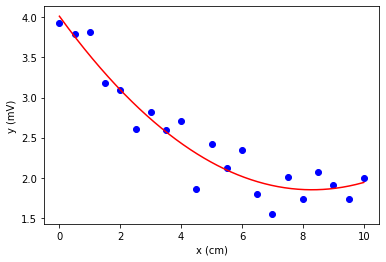

Parameters and 2-sigma parameter uncertainties:
p0 = 4.0145 +/- 0.26797
p1 = -0.52191 +/- 0.12418
p2 = 0.031458 +/- 0.011989

Reduced chi-squared = 0.05039


In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from numpy import sqrt
from scipy.optimize import curve_fit

# Read in the data (the file data0.txt should be in
# the same folder as this Jupyter Notebook)
darray = np.loadtxt('data0.txt')

# Slice out the x and y columns
xs = darray[:,0]
ys = darray[:,1]

# Define the model function
def f(x,p0,p1,p2):
    ymod = p0 + p1*x + p2*x**2
    return ymod

# Use curve_fit to fit the data
guesses = (0,0,0)   # parameter guesses
(p0,p1,p2),cc = curve_fit(f,xs,ys,p0=guesses)

# Make arrays xmod, ymod of the model with 500 points covering 
# the same range as the data
xmin = min(xs)
xmax = max(xs)
xmod = np.linspace(xmin,xmax,500)
ymod = f(xmod,p0,p1,p2)

# Plot the data and the model together
plt.plot(xs,ys,'bo')                  # plot the data
plt.plot(xmod,ymod,'r')               # plot the model
plt.xlabel('x (cm)')
plt.ylabel('y (mV)')
plt.show()

# Print parameters and their 2-sigma uncertainties:
up0,up1,up2 = 2*sqrt(np.diag(cc)) # diagonal of cc gives param variances
print('Parameters and 2-sigma parameter uncertainties:')
print(f'p0 = {p0:.5} +/- {up0:.5}')
print(f'p1 = {p1:.5} +/- {up1:.5}')
print(f'p2 = {p2:.5} +/- {up2:.5}')

# Compute reduced chi-squared:
yfit = f(xs,p0,p1,p2)
yys = (yfit-ys)**2
dof = len(xs) - len(guesses)    # degrees of freedom
chisqr = sum(yys)/dof
print(f'\nReduced chi-squared = {chisqr:.5f}')